# Observation Baseline Before/After Pilot Start
Weekends have been ommited (for now) since there is insufficient data.

In [1]:
%matplotlib inline
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
from datetime import datetime, timedelta, date
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pandas.io.sql as pandasql
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
# setting up pgsql connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

Baseline code taken from [bluetooth baseline anaylsis](https://github.com/CityofToronto/bdit_king_pilot_dashboard/blob/data_pipeline/bluetooth/bluetooth_baselines.ipynb). It has been modified to perform analysis on number of observations before/after King Street Pilot.

In [3]:
cut_days = ['2017-10-22', '2017-11-19']

Removes invalid days.

In [4]:
cut_day_str = '(\'' + cut_days[0]
for day in cut_days[1:]:
    cut_day_str = cut_day_str + '\', \'' + day
cut_day_str = cut_day_str + '\')'

In [161]:
def get_after_data(street):
    sql_mod = pg.SQL('''
    WITH bt as(
        SELECT * 
            FROM ryu4.aggr_30min blu
            WHERE blu.datetime_bin::date NOT IN ('2017-10-22', '2017-11-19')
            AND datetime_bin::date > '2017-11-12')
    SELECT '2017-11-12'::date + datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.obs) as observations,
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
        aa.report_name
    FROM  bt
        INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    WHERE hol.dt is NULL AND EXTRACT(ISODOW FROM bt.datetime_bin) < 6
        AND aa.report_name = {street}
    GROUP BY aa.report_name, 
        datetime_bin::time, 
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
    ''').format(street = pg.Literal(street))
    after_base = pandasql.read_sql(sql_mod, con)
    return after_base

In [162]:
def get_before_data(street):
    sql_mod = pg.SQL('''
    WITH bt as(
        SELECT * 
            FROM ryu4.aggr_30min blu
            WHERE blu.datetime_bin::date NOT IN ('2017-10-22', '2017-11-19')
            AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29')
    SELECT '2017-11-12'::date + datetime_bin::time as time, 
        percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.obs) as observations,
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
        aa.report_name
    FROM  bt
        INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
        LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
    WHERE hol.dt is NULL AND EXTRACT(ISODOW FROM bt.datetime_bin) < 6
        AND aa.report_name = {street}
    GROUP BY aa.report_name, 
        datetime_bin::time, 
        CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
    ''').format(street = pg.Literal(street))
    before_base = pandasql.read_sql(sql_mod, con)
    return before_base

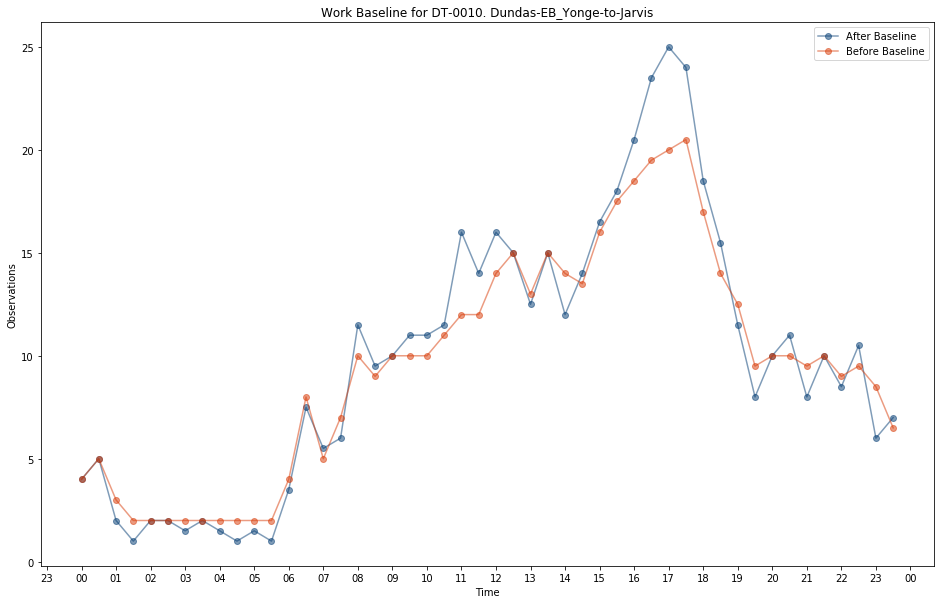

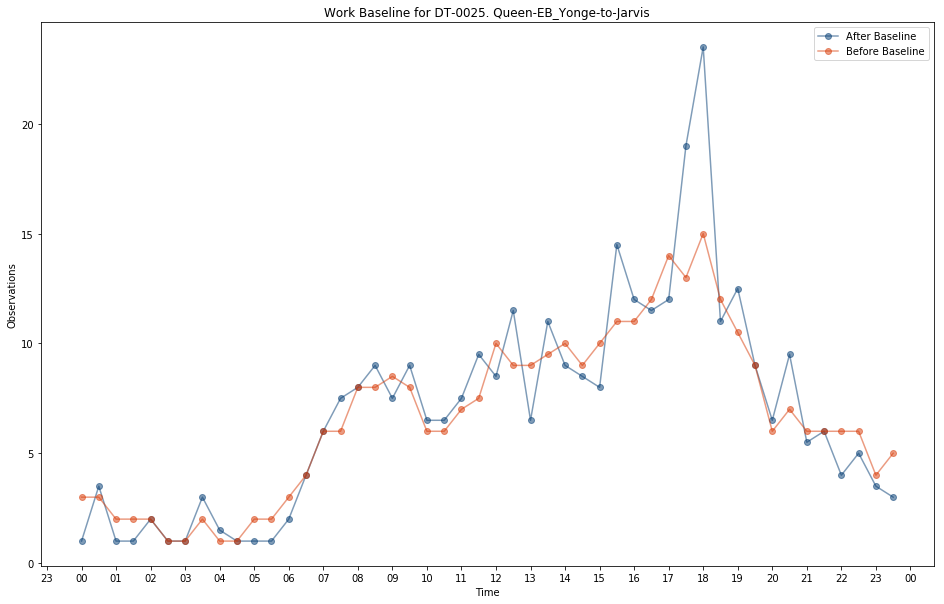

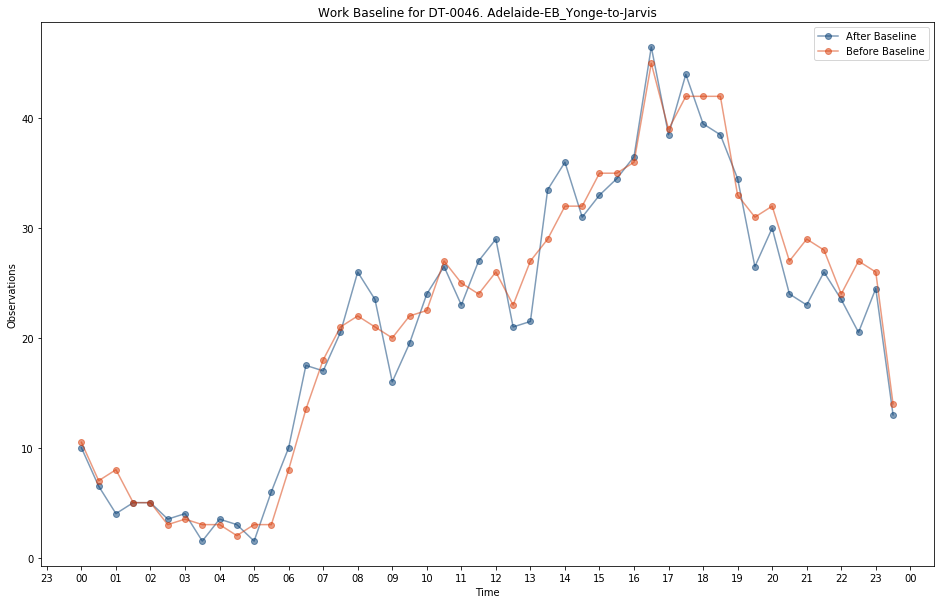

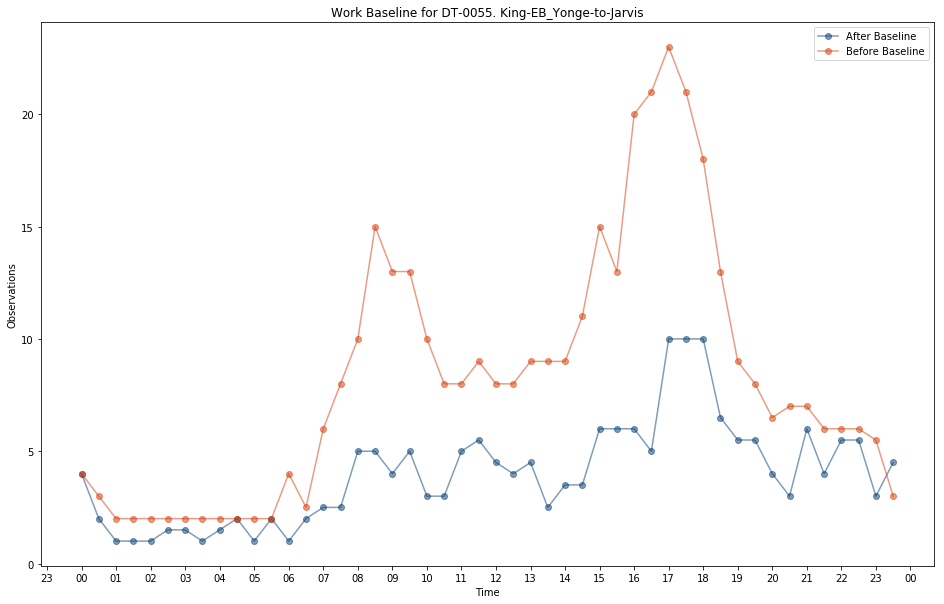

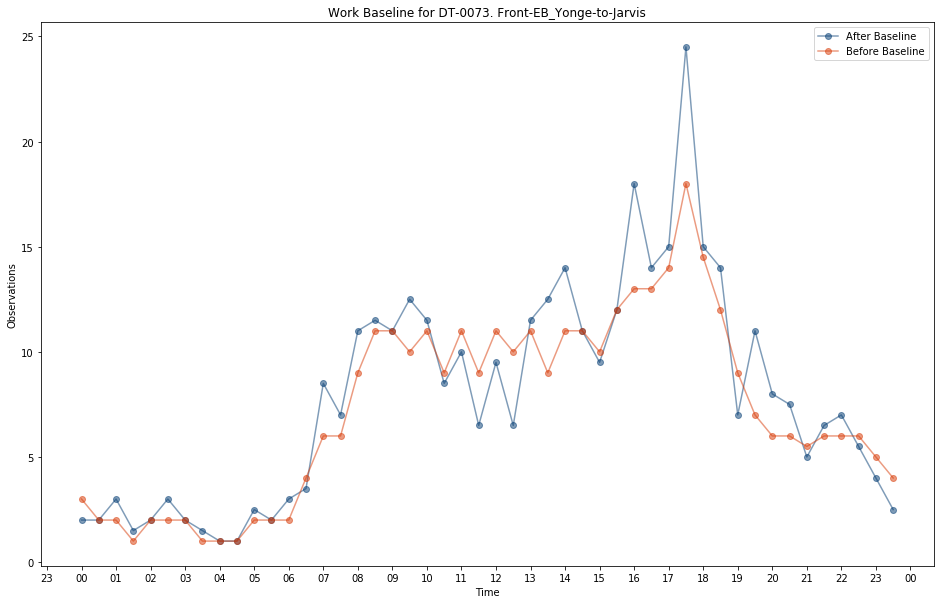

In [159]:
sample_set = ['DT-0010. Dundas-EB_Yonge-to-Jarvis', 'DT-0025. Queen-EB_Yonge-to-Jarvis',
              'DT-0046. Adelaide-EB_Yonge-to-Jarvis', 'DT-0055. King-EB_Yonge-to-Jarvis',
              'DT-0073. Front-EB_Yonge-to-Jarvis']
for street in sample_set:
    before = get_before_data(street)
    after = get_after_data(street)

    pct_change = [y[1] / x[1] for (x, y) in zip(before.values, after.values)]
    time = [x[0] for (x, y) in zip(before.values, after.values)]
    fig, ax = plt.subplots(1, 1, figsize = (16,10))

    after_baseline = ax.plot(after.time,
                after.observations.values,
                '-o',
                c = colors[0],
                alpha = 0.5)
    before_baseline = ax.plot(before.time,
                before.observations,
                '-o',
                c = colors[1],
                alpha = 0.5)
    
    #before.get_xaxis().set_visible(False)
    #before.get_yaxis().set_visible(False)
    plt.title(str('Work') + ' Baseline for ' + street)
    ax.xaxis.set_label_text('Time')
    ax.yaxis.set_label_text('Observations')
    ax.legend((after_baseline[0], before_baseline[0]), ('After Baseline', 'Before Baseline'))
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

    plt.show()


# Peak Time Changes

Percentage change of Normalized AM peak time observation changes

In [95]:
def get_peak_changes(ew_street, ns_segment, start, end):
    sql_mod = pg.SQL('''
    WITH after as (
        WITH bt as(
            SELECT * 
                FROM ryu4.aggr_30min blu
                WHERE blu.datetime_bin::date NOT IN ('2017-10-22', '2017-11-19')
                AND datetime_bin::date > '2017-11-12'
                AND blu.report_name SIMILAR TO {ew_street}
                AND blu.report_name SIMILAR TO {ns_segment})
        SELECT
            percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.obs) as observations,
            CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
            aa.report_name
        FROM  bt
            INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
            LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
        WHERE hol.dt is NULL AND EXTRACT(ISODOW FROM bt.datetime_bin) < 6
            AND bt.datetime_bin::time >= {start} AND bt.datetime_bin::time <= {end}
        GROUP BY aa.report_name, 
            CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
    ),
    before as(
        WITH bt as(
            SELECT * 
                FROM ryu4.aggr_30min blu
                WHERE blu.datetime_bin::date NOT IN ('2017-10-22', '2017-11-19')
                AND datetime_bin::date NOT BETWEEN '2017-10-15' AND '2017-10-29'
                AND blu.report_name SIMILAR TO {ew_street}
                AND blu.report_name SIMILAR TO {ns_segment})
        SELECT
            percentile_cont(0.5) WITHIN GROUP(ORDER BY bt.obs) as observations,
            CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END as workingday,
            aa.report_name
        FROM  bt
            INNER JOIN bluetooth.all_analyses aa USING(analysis_id)
            LEFT OUTER JOIN ref.holiday hol ON (bt.datetime_bin::DATE = hol.dt)
        WHERE hol.dt is NULL AND EXTRACT(ISODOW FROM bt.datetime_bin) < 6
            AND bt.datetime_bin::time >= {start} AND bt.datetime_bin::time <= {end}
        GROUP BY aa.report_name, 
            CASE WHEN EXTRACT(ISODOW FROM bt.datetime_bin) < 6 THEN 'Work' ELSE 'Weekend' END
    )
    SELECT round(((after.observations - before.observations) / before.observations) * 100) AS pct_chg
    FROM after
    INNER JOIN before ON before.report_name = after.report_name
    ''').format(ew_street = pg.Literal('% ' + ew_street + '-%'), ns_segment = pg.Literal('%' + ns_segment), 
                start = pg.Literal(start), end = pg.Literal(end))
    pct_change = pandasql.read_sql(sql_mod, con)
    return pct_change

In [100]:
am_peak_start = '7:00:00'
am_peak_end = '10:00:00'

ew_streets = ['Queen', 'Richmond', 'Adelaide', 'King', 'Front']
ns_segments = ['Bathurst-to-Spadina', 'Spadina-to-Bathurst', 'Spadina-to-University', 'University-to-Spadina',
               'Yonge-to-Jarvis', 'Jarvis-to-Yonge', 'Jarvis-to-Parliament', 'Parliament-to-Jarvis']

pct_change_am = {}
for segment in ns_segments:
    segment_pct_change = {}
    for street in ew_streets:
        segment_data = get_peak_changes(street, segment, am_peak_start, am_peak_end)
        segment_pct_change[street] = '-' if not segment_data.pct_chg.values else segment_data.pct_chg.values[0]
    pct_change_am[segment] = segment_pct_change

In [101]:
am_chg_table = pd.DataFrame.from_dict(pct_change_am)
HTML(am_chg_table.to_html(columns=ns_segments))

,Bathurst-to-Spadina,Spadina-to-Bathurst,Spadina-to-University,University-to-Spadina,Yonge-to-Jarvis,Jarvis-to-Yonge,Jarvis-to-Parliament,Parliament-to-Jarvis
Adelaide,-,-,-11,-,5,-,10,-
Front,-10,-,17,-50,22,-,17,11
King,-57,-57,-58,-40,-60,-58,-60,-41
Queen,18,19,18,17,7,12,6,11
Richmond,-,-,-,-,-,8,-,-1


In [102]:
pm_peak_start = '16:00:00'
pm_peak_end = '19:00:00'

pct_change_pm = {}
for segment in ns_segments:
    segment_pct_change = {}
    for street in ew_streets:
        segment_data = get_peak_changes(street, segment, pm_peak_start, pm_peak_end)
        segment_pct_change[street] = '-' if not segment_data.pct_chg.values else segment_data.pct_chg.values[0]
    pct_change_pm[segment] = segment_pct_change

In [103]:
pm_chg_table = pd.DataFrame.from_dict(pct_change_pm)
HTML(pm_chg_table.to_html(columns=ns_segments))

,Bathurst-to-Spadina,Spadina-to-Bathurst,Spadina-to-University,University-to-Spadina,Yonge-to-Jarvis,Jarvis-to-Yonge,Jarvis-to-Parliament,Parliament-to-Jarvis
Adelaide,-,-,-7,-,-2,-,1,-
Front,12,-,-,-,19,-,12,22
King,-50,-45,-62,-25,-61,-44,-54,-18
Queen,10,4,12,-,-,14,8,12
Richmond,-,-,-,-,-,-11,-,2
